In [10]:
"""Prototype for cube wrapper script around PAHFIT.

For now, it will only work for the cubes of the SAGE-Spec program.

Given a set of data cubes, a set of spectra is extracted by performing
aperture photometry on each slice. The apertures used are rectangular
and adjacent in the pixel space of the map we are trying to create. The
axes of the map align with RA,DEC by construction. 

We use a manually created WCS to turn the pixel grid into a coordinate
grid with equal angular separation along each axis. The coordinates are
used to create a set sky-apertures, which can then be used to perform
aperture photometry on the cube slices, given the right WCS for each
cube.

"""
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy import units as u
from pathlib import Path
from matplotlib import pyplot as plt
from photutils.aperture import SkyRectangularAperture, aperture_photometry
import reproject
from collections import namedtuple
from dataclasses import dataclass


@dataclass
class Cube:
    file_handle: fits.HDUList
    data: np.ndarray
    wavelength: np.ndarray
    wcs: WCS

@dataclass
class CubeSet:
    """The four cubes we have for each object

    Constructor is automatically generated"""

    ll1: Cube
    ll2: Cube
    sl1: Cube
    sl2: Cube

    def all_cubes(self):
        """You can add functions to this type of class like this"""
        return [self.ll1, self.ll2, self.sl1, self.sl2]


def read_spitzer_cube(fn):
    """
    Get the data cube, wavelength table and WCS.

    Returns
    -------
    Cube
    """
    hdulist = fits.open(fn)
    wavs = Table.read(fn)["WAVELENGTH"][0].flatten()
    wcs = WCS(fn, naxis=2)
    return Cube(file_handle=hdulist, data=hdulist[0].data, wavelength=wavs, wcs=wcs)


def get_SAGE_cubes(target, uncertainty=False):
    """Get all 4 Spitzer IFU cubes (LL1, LL2, SL1, SL2).

    uncertainty : if True, loads the uncertainty cubes instead

    Returns
    -------
    CubeSet
    """
    dname = f"data/sage-spec_{target}_4dec08"
    d = Path(dname)
    # load them in the right order...
    cube_names = ["ll_LL1", "ll_LL2", "sl_SL1", "sl_SL2"]
    cubes = []
    for cube_name in cube_names:
        fname = f"{target}_{cube_name}_cube.fits"
        # reuse this function
        if uncertainty:
            fname = fname.replace("cube.fits", "cube_unc.fits")
        cubes.append(read_spitzer_cube(str(d / fname)))

    # ... in the future we can unambiguously access them here
    return CubeSet(*cubes)


def quicklook_cubes(cube_set, apertures=None):
    """Display the 4 cubes and a set of apertures in a 2x2 grid."""
    fig = plt.gcf()
    for i, cube in enumerate(cube_set.all_cubes()):
        ax = fig.add_subplot(2, 2, i + 1, projection=cube.wcs)
        ax.imshow(cube.data[-1])
        ax.grid()
        ax.coords[0].set_format_unit(u.degree, decimal=True)
        ax.coords[1].set_format_unit(u.degree, decimal=True)
        if apertures is not None:
            apertures.to_pixel(cube.wcs).plot(axes=ax, color="r")


# the wcs we want our final map to have
def make_ra_dec_wcs(center_ra, center_dec, pix_angle_delta, npix_ra, npix_dec):
    """Make simple WCS where X and Y are aligned with RA and DEC, respectively.

    center_ra, center_dec: determines crval

    pix_angle_delta: physical distance between pixels, in decimal degrees

    npix_ra, npix_dec: number of pixels along each axis. Is needed to
    make sure that (center_ra, center_dec) corresponds to the middle of
    the image. The physical image size will be pix_angle_delta * npix.

    """
    w = WCS(naxis=2)
    # center of each pixel = 1, 2, 3, ...
    # 3 pixels --> center is 2
    # 4 pixels --> center is 2.5 (border between 2 and 3)
    center_x = npix_ra / 2 + 0.5
    center_y = npix_dec / 2 + 0.5
    w.wcs.crpix = [center_x, center_y]
    w.wcs.crval = [center_ra, center_dec]
    w.wcs.cdelt = [-pix_angle_delta, pix_angle_delta]
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    return w


def reproject_and_merge_cubes(
    cube_set, center_ra, center_dec, pix_angle_delta, npix_ra, npix_dec, filename=None
):
    """
    Reproject all four cubes onto pixel grid wcs, and merge the result.

    Result is sorted by wavelength"""
    output_projection = make_ra_dec_wcs(
        center_ra, center_dec, pix_angle_delta, npix_ra, npix_dec
    )
    output_wavs = np.concatenate([c.wavelength for c in cube_set.all_cubes()]).flatten()
    nw = len(output_wavs)

    ny, nx = npix_dec, npix_ra
    output_cube_array = np.zeros((nw, ny, nx))

    start = 0
    for c in cube_set.all_cubes():
        stop = start + len(c.wavelength)
        output_cube_array[start:stop] = reproject_cube(c, output_projection, ny, nx)
        start = stop

    # stitching here

    order = np.argsort(output_wavs)
    output_wavs = output_wavs[order]
    output_cube_array = output_cube_array[order]

    if filename is not None:
        # multi extension (wav list and cube)
        new_hdul = fits.HDUList()
        # cube as primary hdu
        header = output_projection.to_header()
        header["PC3_3"] = 1
        header["CRPIX3"] = 1
        header["CRVAL3"] = 1
        header["CTYPE3"] = "WAVE-TAB"
        header["CUNIT3"] = "um"
        header["PS3_0"] = "WCS-TAB"
        header["PS3_1"] = "WAVELENGTH"
        header["BUNIT"] = "MJy/sr"
        new_hdul.append(fits.PrimaryHDU(data=output_cube_array, header=header))
        # wavs as bintable hdu
        wav_col = fits.Column(name="WAVELENGTH", array=output_wavs, format="D")
        wavhdu = fits.BinTableHDU.from_columns([wav_col])
        wavhdu.header["EXTNAME"] = "WCS-TAB"
        wavhdu.header["TUNIT1"] = "um"
        new_hdul.append(wavhdu)
        # write
        new_hdul.writeto(filename, overwrite=True)

    return output_wavs, output_cube_array


def reproject_cube(cube, wcs, ny, nx):
    """
    Reproject every slice of cube onto wcs, ny, nx.

    Returns
    -------
    output_array: np.ndarray indexed on wavelength, y, x
    """
    num_wavs = len(cube.wavelength)
    input_array = cube.data
    input_wcs = cube.wcs

    output_array = np.zeros((num_wavs, ny, nx))
    for w in range(num_wavs):
        output_array[w], footprint = reproject.reproject_adaptive(
            input_data=(input_array[w], input_wcs),
            output_projection=wcs,
            shape_out=(ny, nx),
        )
    return output_array

In [11]:
center_ra = 73.03
center_dec = -66.923
npix_ra = 15
npix_dec = 10
pix_angle_delta = 0.001
target = "hii1_hii8"
cube_set = get_SAGE_cubes(target)
dir(cube_set)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'all_cubes',
 'll1',
 'll2',
 'sl1',
 'sl2']

In [32]:
output_projection = make_ra_dec_wcs(
        center_ra, center_dec, pix_angle_delta, npix_ra, npix_dec
    )

reprojected_cube_set = CubeSet(
    *[Cube(file_handle=None,
           data=reproject_cube(c, output_projection, npix_ra, npix_dec),
           wavelength=c.wavelength, 
           wcs=output_projection)
      for c in cube_set.all_cubes()])


In [33]:
# plot a few pixels to check the result
def plot_few_pixels(reprojected_cube_set):
    pixels = [(7, 8), (5, 4)]
    colors = ['b', 'r']
    for (y, x), color in zip(pixels, colors):
        for c in reprojected_cube_set.all_cubes()[:2]:
            plt.plot(c.wavelength, c.data[:, y, x], color=color)

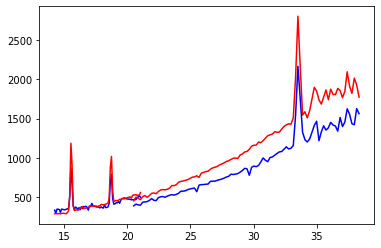

In [34]:
plot_few_pixels(reprojected_cube_set)

In [35]:
# stitching here, so we can't just treat all cubes equally

# stitch between ll1 and ll2 by adjusting ll2 (we're going from long to short wav)
ll1wav = reprojected_cube_set.ll1.wavelength
ll1dat = reprojected_cube_set.ll1.data
ll2wav = reprojected_cube_set.ll2.wavelength
ll2dat = reprojected_cube_set.ll2.data

ll1_minwav = np.amin(ll1wav)
ll2_maxwav = np.amax(ll2wav)
print(ll1_minwav, ll2_maxwav)

20.52005 21.051888


In [36]:
# sum of pixels in overlap window
ll1_sum = ll1dat[ll1wav < ll2_maxwav].sum()
ll2_sum = ll2dat[ll2wav > ll1_minwav].sum()

print(ll2_sum)
print(ll1_sum)

135799.7646920018
80760.53343286901


In [37]:
# rescale ll2 data
reprojected_cube_set.ll2.data *= ll1_sum / ll2_sum

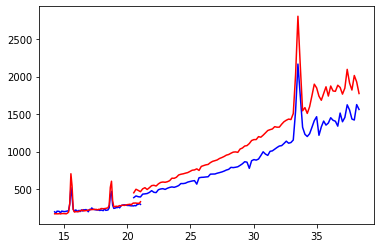

In [38]:
plot_few_pixels(reprojected_cube_set)

### Does not work, try pixel-per-pixel stitching

In [29]:

start = 0
for c in cube_set.all_cubes():
    stop = start + len(c.wavelength)
    output_cube_array[start:stop] = reproject_cube(c, output_projection, ny, nx)
    start = stop

order = np.argsort(output_wavs)
output_wavs = output_wavs[order]
output_cube_array = output_cube_array[order]

[{'filename': 'data/sage-spec_hii1_hii8_4dec08/hii1_hii8_ll_LL1_cube.fits',
  'cube': <astropy.io.fits.hdu.image.PrimaryHDU at 0x109cb02b0>,
  'wavelength': array([[20.52005 ],
         [20.696583],
         [20.873219],
         [21.049953],
         [21.226791],
         [21.403732],
         [21.580776],
         [21.757923],
         [21.935171],
         [22.112522],
         [22.289978],
         [22.467537],
         [22.645199],
         [22.822968],
         [23.000837],
         [23.17881 ],
         [23.35689 ],
         [23.535074],
         [23.713362],
         [23.891756],
         [24.070255],
         [24.248857],
         [24.427567],
         [24.606384],
         [24.785305],
         [24.96433 ],
         [25.143463],
         [25.322704],
         [25.50205 ],
         [25.681503],
         [25.861065],
         [26.040731],
         [26.220507],
         [26.400389],
         [26.58038 ],
         [26.760477],
         [26.940683],
         [27.120998],
         

In [16]:
start = 0
for d in cube_dicts:
    stop = start + len(d["wavelength"])
    output_cube_array[start:stop] = reproject_cube(d, output_projection, ny, nx)
    start = stop

# stitching here

order = np.argsort(output_wavs)
output_wavs = output_wavs[order]
output_cube_array = output_cube_array[order]